# Chapter 2: Financial Data Engineering and Pipeline Architecture

## 1. Multi-Source Data Ingestion: Market Data (Alpaca, Polygon), Alternative Data, News Feeds

Modern AI financial trading systems thrive on a rich diet of diverse data sources. These include traditional market data vendors like Alpaca and Polygon.io, alternative datasets offering unique insights, and real-time news feeds capturing market sentiment. Robust architectures are crucial to guarantee consistent, timely, and reliable data ingestion from these varied sources.

Part 1: Data Ingestion with Alpaca
The alpaca-trade-api library provides a straightforward way to interact with the Alpaca API.

Synchronous Ingestion with Alpaca
This is the standard approach. We make a request and wait for the response. It's simple and effective for single-symbol lookups.

In [10]:
# pip install alpaca-py pandas polygon-api-client
import os
import asyncio
import pandas as pd
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

# --- Setup ---
# Set environment variables
os.environ["APCA_API_KEY_ID"] = "PK2PFB24ARRQ9IO7410P"
os.environ["APCA_SECRET_KEY"] = "zcnojzOUAAd5453tQNDXoKIpulL755NzO6Dv3Fv6"

In [11]:
# Setup API connection
api = StockHistoricalDataClient(
    os.getenv("APCA_API_KEY_ID"),
    os.getenv("APCA_SECRET_KEY")
)

# --- Synchronous Fetch ---
def fetch_sync_alpaca(symbol):
    """Fetches historical data for a single symbol synchronously."""
    print(f"Fetching {symbol} data...")
    request_params = StockBarsRequest(
                        symbol_or_symbols=[symbol],
                        timeframe=TimeFrame.Day,
                        start="2023-01-01",
                        end="2023-01-31"
                 )
    bars = api.get_stock_bars(request_params).df
    print(f"Finished fetching {symbol} data.")
    return bars

# --- Execution ---
if __name__ == "__main__":
    spy_data = fetch_sync_alpaca("SPY")
    print("\nSPY Data (First 5 Rows):")
    print(spy_data.head())

Fetching SPY data...
Finished fetching SPY data.

SPY Data (First 5 Rows):
                                    open    high       low   close  \
symbol timestamp                                                     
SPY    2023-01-03 05:00:00+00:00  384.37  386.43  377.8310  380.82   
       2023-01-04 05:00:00+00:00  383.18  385.88  380.0000  383.76   
       2023-01-05 05:00:00+00:00  381.72  381.84  378.7600  379.38   
       2023-01-06 05:00:00+00:00  382.61  389.25  379.4127  388.08   
       2023-01-09 05:00:00+00:00  390.37  393.70  387.6700  387.86   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
SPY    2023-01-03 05:00:00+00:00   74850731.0     590240.0  380.745269  
       2023-01-04 05:00:00+00:00   85934098.0     632808.0  383.265078  
       2023-01-05 05:00:00+00:00   76970456.0     530899.0  380.035868  
       2023-01-06 05:00:00+00:00  104026233.0     685781.0  385.90232

Asynchronous Ingestion with Alpaca
When you need data for many symbols, doing it synchronously is slow. Asynchronous fetching allows us to request data for all symbols concurrently, dramatically reducing wait times.

The alpaca-py library supports async operations out of the box.

In [12]:
# --- Async Setup ---
api = StockHistoricalDataClient(
    api_key=os.getenv("APCA_API_KEY_ID"),
    secret_key=os.getenv("APCA_SECRET_KEY")
)

# --- Asynchronous Fetch ---
async def fetch_async_alpaca(symbol):
    """An async coroutine to fetch historical data for one symbol."""
    print(f"Fetching {symbol} data...")
    request_params = StockBarsRequest(
                        symbol_or_symbols=[symbol],
                        timeframe=TimeFrame.Day,
                        start="2023-01-01",
                        end="2023-01-31"
                 )
    # Use asyncio.to_thread to run the synchronous get_stock_bars method in a separate thread
    bars = await asyncio.to_thread(api.get_stock_bars, request_params)
    print(f"Finished fetching {symbol} data.")
    return symbol, bars.df

# --- Async Execution ---
async def main():
    symbols = ["AAPL", "GOOG", "MSFT", "TSLA"]
    # Create a list of tasks to run concurrently
    tasks = [fetch_async_alpaca(symbol) for symbol in symbols]
    # Run all tasks and wait for them to complete
    results = await asyncio.gather(*tasks)

    # Process results
    dataframes = {symbol: df for symbol, df in results}
    print("\n--- All Data Fetched ---")
    print(f"AAPL Data Head:\n{dataframes['AAPL'].head()}")
    print(f"\nMSFT Data Head:\n{dataframes['MSFT'].head()}")


# In a Jupyter Notebook, you can run the async main function by awaiting it.
await main()


Fetching AAPL data...
Fetching GOOG data...
Fetching MSFT data...
Fetching TSLA data...
Finished fetching AAPL data.
Finished fetching MSFT data.
Finished fetching TSLA data.
Finished fetching GOOG data.

--- All Data Fetched ---
AAPL Data Head:
                                     open      high     low   close  \
symbol timestamp                                                      
AAPL   2023-01-03 05:00:00+00:00  130.280  130.9000  124.17  125.07   
       2023-01-04 05:00:00+00:00  126.890  128.6557  125.08  126.36   
       2023-01-05 05:00:00+00:00  127.130  127.7700  124.76  125.02   
       2023-01-06 05:00:00+00:00  126.010  130.2900  124.89  129.62   
       2023-01-09 05:00:00+00:00  130.465  133.4100  129.89  130.15   

                                       volume  trade_count        vwap  
symbol timestamp                                                        
AAPL   2023-01-03 05:00:00+00:00  124289279.0    1021067.0  125.660032  
       2023-01-04 05:00:00+00:00   95

Part 2: Data Ingestion with Polygon.io
The official polygon-python-v3 client also supports both sync and async operations.

Synchronous Ingestion with Polygon
Similar to Alpaca, the synchronous approach is direct and easy to implement.

In [13]:
import asyncio
import os
import datetime
import pandas as pd
from polygon import RESTClient

os.environ["POLYGON_API_KEY"] = "lPFUNg2rAv_XMYBOfIcW9pJfoLJF1pfO"

In [14]:
# --- Setup ---
client = RESTClient(api_key=os.getenv("POLYGON_API_KEY"))

# --- Synchronous Fetch ---
def fetch_sync_polygon(symbol):
    """Fetches historical aggregates for a single symbol."""
    print(f"Fetching {symbol} data...")
    
    # Get the last trading day
    today = datetime.date.today()
    if today.weekday() == 0: # Monday
        last_trading_day = today - datetime.timedelta(days=3)
    elif today.weekday() == 6: # Sunday
        last_trading_day = today - datetime.timedelta(days=2)
    else: # Other days
        last_trading_day = today - datetime.timedelta(days=1)
        
    last_trading_day_str = last_trading_day.strftime("%Y-%m-%d")
    
    aggs = client.get_aggs(
        ticker=symbol,
        multiplier=1,
        timespan="minute",
        from_=last_trading_day_str,
        to=last_trading_day_str,
    )
    print(f"Finished fetching {symbol} data.")
    df = pd.DataFrame(aggs)
    if not df.empty:
        print("Available columns:", df.columns)
    return df

# --- Execution ---
if __name__ == "__main__":
    aapl_data = fetch_sync_polygon("AAPL")
    print("\nAAPL Data (First 5 Rows):")
    print(aapl_data.head())


Fetching AAPL data...
Finished fetching AAPL data.
Available columns: Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'timestamp',
       'transactions', 'otc'],
      dtype='object')

AAPL Data (First 5 Rows):
     open    high     low   close   volume      vwap      timestamp  \
0  246.13  246.82  245.30  245.35  13203.0  245.7052  1758528000000   
1  245.50  245.50  245.38  245.50   2568.0  245.4576  1758528060000   
2  245.61  245.62  245.20  245.20  16896.0  245.3025  1758528120000   
3  245.16  245.40  245.10  245.11   8056.0  245.2496  1758528180000   
4  245.20  245.20  245.08  245.16   2378.0  245.1581  1758528240000   

   transactions   otc  
0           362  None  
1           181  None  
2           395  None  
3           210  None  
4           125  None  


Asynchronous Ingestion with Polygon
Using Polygon's AsyncRESTClient, we can achieve high-performance concurrent data fetching.

In [15]:
async def get_aggs_async(client, ticker, from_date, to_date):
    """
    Asynchronously gets aggregate data by running the synchronous SDK method in a thread.
    """
    return await asyncio.to_thread(
        client.get_aggs,
        ticker=ticker,
        multiplier=1,
        timespan="minute",
        from_=from_date,
        to=to_date,
        limit=50000,
    )

async def main():
    client = RESTClient(os.getenv("POLYGON_API_KEY"))
    ticker = "AAPL"
    print(f"Fetching aggregates for {ticker}...")
    
    # Get the last trading day
    today = datetime.date.today()
    if today.weekday() == 0: # Monday
        last_trading_day = today - datetime.timedelta(days=3)
    elif today.weekday() == 6: # Sunday
        last_trading_day = today - datetime.timedelta(days=2)
    else: # Other days
        last_trading_day = today - datetime.timedelta(days=1)
        
    last_trading_day_str = last_trading_day.strftime("%Y-%m-%d")
    
    aggs = await get_aggs_async(client, ticker, last_trading_day_str, last_trading_day_str)
    
    print(f"Found {len(aggs)} aggregate bars.")
    if aggs:
        df = pd.DataFrame(aggs)
        print("Available columns:", df.columns)
        print("\nAAPL Data (First 5 Rows):")
        print(df.head())

# In a Jupyter cell, you can run this:
await main()

Fetching aggregates for AAPL...
Found 870 aggregate bars.
Available columns: Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'timestamp',
       'transactions', 'otc'],
      dtype='object')

AAPL Data (First 5 Rows):
     open    high     low   close   volume      vwap      timestamp  \
0  246.13  246.82  245.30  245.35  13203.0  245.7052  1758528000000   
1  245.50  245.50  245.38  245.50   2568.0  245.4576  1758528060000   
2  245.61  245.62  245.20  245.20  16896.0  245.3025  1758528120000   
3  245.16  245.40  245.10  245.11   8056.0  245.2496  1758528180000   
4  245.20  245.20  245.08  245.16   2378.0  245.1581  1758528240000   

   transactions   otc  
0           362  None  
1           181  None  
2           395  None  
3           210  None  
4           125  None  


## 2. Advanced ETL for Financial Data: Handling Irregularities, Corporate Actions, Survivorship Bias

Advanced Extract, Transform, Load (ETL) processes are crucial for financial data to ensure its quality and reliability for AI models. This involves meticulous cleansing to correct irregularities and inconsistencies. A key aspect is accurately adjusting for corporate actions like stock splits, dividends, and mergers, which can drastically alter historical price series if not handled correctly. Furthermore, robust ETL systems must actively mitigate survivorship bias, ensuring that historical datasets include delisted or failed assets, preventing an overly optimistic view of past performance. Workflow orchestration tools such as Apache Airflow or Prefect are essential for managing these complex, multi-stage ETL pipelines, providing scalability, reliability, and monitoring for critical financial data infrastructure.

In [2]:
import yfinance as yf
import pandas as pd

def etl_pipeline(ticker, period="1y", window=20):
    """
    A simple ETL pipeline for market data.
    """
    # --- Extract ---
    print(f"Extracting data for {ticker}...")
    stock_data = yf.download(ticker, period=period, progress=False)
    
    # --- Transform ---
    print("Transforming data...")
    # Handle missing values (if any)
    stock_data.dropna(inplace=True)
    
    # Add a simple moving average
    stock_data[f'SMA_{window}'] = stock_data['Close'].rolling(window=window).mean()
    
    # --- Load ---
    print("Loading data...")
    # For this example, we'll just display the transformed data.
    # In a real-world scenario, you would load this into a database or file.
    print(f"\nTransformed data for {ticker}:")
    print(stock_data.tail())
    
    return stock_data

# --- Run the pipeline ---
if __name__ == "__main__":
    transformed_data = etl_pipeline("AAPL")

Extracting data for AAPL...


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_26473/1937871988.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, period=period, progress=False)


Transforming data...
Loading data...

Transformed data for AAPL:
Price            Close        High         Low        Open     Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
Date                                                                    
2025-09-17  238.990005  240.100006  237.729996  238.970001   46508000   
2025-09-18  237.880005  241.199997  236.649994  239.970001   44249600   
2025-09-19  245.500000  246.300003  240.210007  241.229996  163741300   
2025-09-22  256.079987  256.640015  248.119995  248.300003  105413200   
2025-09-23  254.699997  257.339996  254.669998  255.875000   32037668   

Price           SMA_20  
Ticker                  
Date                    
2025-09-17  232.747500  
2025-09-18  233.341000  
2025-09-19  234.371001  
2025-09-22  235.787000  
2025-09-23  237.164000  


## 3. Real-Time Streaming vs Batch Processing: Architecture Trade-offs and Hybrid Approaches

In AI financial trading, data processing architectures balance real-time streaming (continuous, low-latency data flow) and batch processing (periodic, high-volume data chunks).

Real-Time Streaming offers immediate insights and rapid reactions (milliseconds to seconds), crucial for high-frequency trading, live risk monitoring, and instant sentiment analysis. Its trade-offs include higher complexity and cost.

Batch Processing handles large historical datasets efficiently and cost-effectively, ideal for model training, backtesting, and complex feature engineering. Its main drawback is high latency, providing delayed insights (minutes to hours).

Real-time

In [10]:
import time
import random

# --- Real-Time Streaming ---

# A simple function to process a single piece of data as it arrives.
def process_real_time_tick(tick_data):
    """
    Processes a single data tick in real-time.
    For demonstration, it checks if the price has crossed a threshold.
    """
    print(f"STREAM >> Received Tick: Price={tick_data['price']:.2f}, Volume={tick_data['volume']}")
    
    # Real-time action: Check for a price alert
    if tick_data['price'] > 155.00:
        print(f"!!! ALERT: Price has exceeded 155.00 !!!")

def simulate_real_time_feed():
    """Simulates a feed of real-time stock data."""
    print("--- Starting Real-Time Streaming Simulation (5 ticks) ---")
    current_price = 150.0
    for _ in range(5):
        # Simulate a new tick arriving
        current_price += random.uniform(-1.5, 1.5)
        tick = {
            'price': current_price,
            'volume': random.randint(100, 2000)
        }
        
        # Process the tick immediately
        process_real_time_tick(tick)
        
        # Wait for the next tick
        time.sleep(1)
    print("--- End of Real-Time Stream ---\n")

# Run the simulation
simulate_real_time_feed()

--- Starting Real-Time Streaming Simulation (5 ticks) ---
STREAM >> Received Tick: Price=150.26, Volume=136
STREAM >> Received Tick: Price=148.83, Volume=1286
STREAM >> Received Tick: Price=147.50, Volume=381
STREAM >> Received Tick: Price=147.44, Volume=277
STREAM >> Received Tick: Price=146.93, Volume=415
--- End of Real-Time Stream ---



Batch

In [11]:
import pandas as pd
import numpy as np

# --- Batch Processing ---

def generate_daily_data_batch():
    """Generates a batch of data, representing a full day of trades."""
    print("--- Generating a Batch of 10,000 Trades ---")
    prices = 150 + np.random.randn(10000).cumsum() * 0.05
    volumes = np.random.randint(100, 5000, 10000)
    return pd.DataFrame({'price': prices, 'volume': volumes})

def process_batch(batch_df):
    """
    Processes an entire batch of data at once.
    For demonstration, it calculates end-of-day summary statistics.
    """
    print(f"BATCH >> Processing a batch of {len(batch_df)} records.")
    
    # Batch calculation: Volume-Weighted Average Price (VWAP)
    vwap = (batch_df['price'] * batch_df['volume']).sum() / batch_df['volume'].sum()
    total_volume = batch_df['volume'].sum()
    avg_price = batch_df['price'].mean()
    
    print(f"--- Batch Processing Complete ---")
    print(f"End-of-Day VWAP: {vwap:.2f}")
    print(f"End-of-Day Average Price: {avg_price:.2f}")
    print(f"End-of-Day Total Volume: {total_volume}")
    print("--- End of Batch Job ---\n")

# Run the simulation
daily_batch = generate_daily_data_batch()
process_batch(daily_batch)

--- Generating a Batch of 10,000 Trades ---
BATCH >> Processing a batch of 10000 records.
--- Batch Processing Complete ---
End-of-Day VWAP: 147.75
End-of-Day Average Price: 147.75
End-of-Day Total Volume: 25510351
--- End of Batch Job ---



## 4. Data Quality Frameworks: Validation, Cleansing, and Anomaly Detection

Maintaining high data quality is paramount in financial AI, as even minor inaccuracies can lead to significant errors in models and trading decisions. Data Quality Frameworks provide structured approaches to ensure data integrity. This involves validation to check data against predefined rules and expectations (e.g., using tools like Great Expectations to automate checks for completeness, uniqueness, and consistency). Cleansing addresses identified issues by correcting or removing erroneous data points. Finally, anomaly detection techniques are employed to automatically identify unusual patterns or outliers, such as sudden, inexplicable price spikes or drops, which could indicate data corruption or critical market events requiring immediate attention. Together, these components build trust in the data powering financial AI systems.

In [ ]:
def clean_data(df):
    df['close'] = df['close'].fillna(method='ffill')
    df = df[df['close'] > 1]
    return df

cleaned_bars = clean_data(bars)
cleaned_bars.head()

In [ ]:
cleaned_bars['pct_change'] = cleaned_bars['close'].pct_change()
anomalies = cleaned_bars[(cleaned_bars['pct_change'] > 0.2) | (cleaned_bars['pct_change'] < -0.2)]
print("Anomalies detected:")
print(anomalies[['close', 'pct_change']])

## 5. Alternative Data Integration: Satellite Imagery, Social Media, Economic Indicators

Financial markets are not only driven by traditional financial data (like prices and volumes) but also by a wide range of **alternative data** sources. This can include everything from satellite imagery of oil tankers to social media sentiment.

Integrating alternative data can provide a unique edge in financial analysis and modeling. In this example, we'll simulate the process of integrating social media sentiment data with our market data.

### The Workflow:

1.  **Fetch Market Data:** Get the historical price data for a stock.
2.  **Fetch Alternative Data:** In a real-world scenario, you would use an API to get social media sentiment scores for the stock. For this example, we will simulate this by generating random sentiment data.
3.  **Combine Data:** Align and combine the two datasets into a single DataFrame. This is a critical step, as you need to ensure that the data is correctly aligned by date.
4.  **Analyze:** With the combined data, you can now explore the relationship between market prices and social sentiment.

Fetching market data for AAPL...


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_53839/626678215.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download(ticker, period=period, progress=False)


Fetching social sentiment data (simulated)...
Combining market and sentiment data...

--- Combined Data (Last 5 Rows) ---
Price            Close        High         Low        Open     Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
Date                                                                    
2025-09-17  238.990005  240.100006  237.729996  238.970001   46508000   
2025-09-18  237.880005  241.199997  236.649994  239.970001   44249600   
2025-09-19  245.500000  246.300003  240.210007  241.229996  163741300   
2025-09-22  256.079987  256.640015  248.119995  248.300003  105413200   
2025-09-23  255.610001  257.339996  255.009995  255.875000   27415373   

Price      Sentiment  
Ticker                
Date                  
2025-09-17 -0.143632  
2025-09-18  0.933310  
2025-09-19  0.927240  
2025-09-22  0.706019  
2025-09-23 -0.411102  


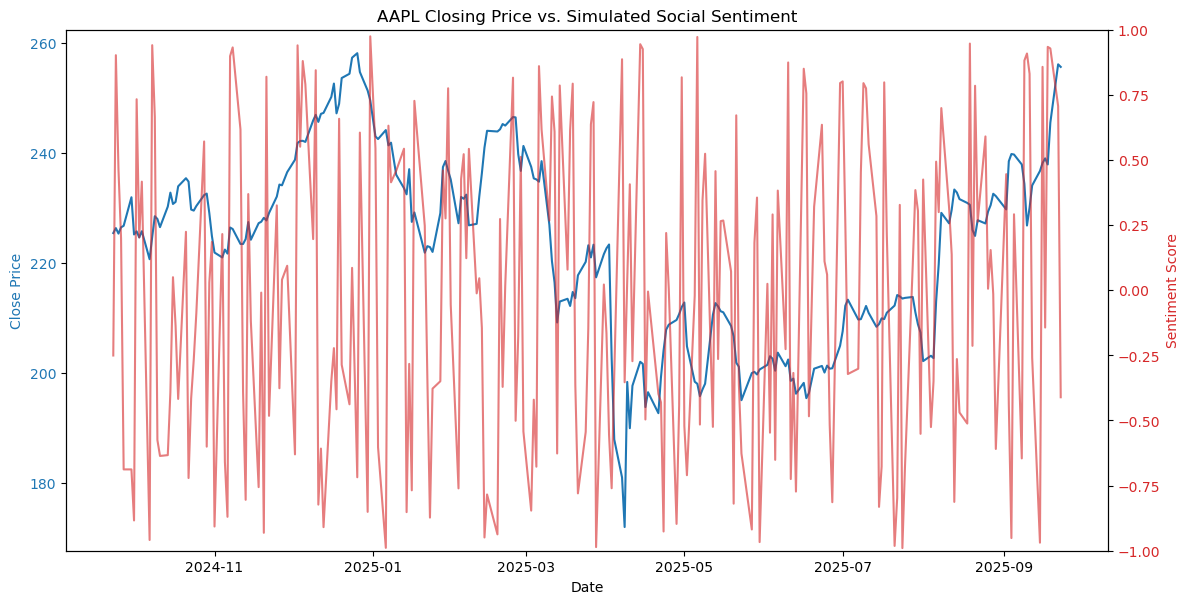

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def integrate_sentiment_data(ticker, period="1y"):
    """
    Simulates the integration of social sentiment data with market data.
    """
    # --- 1. Fetch Market Data ---
    print(f"Fetching market data for {ticker}...")
    market_data = yf.download(ticker, period=period, progress=False)
    
    # --- 2. Fetch Alternative Data (Simulated) ---
    print("Fetching social sentiment data (simulated)...")
    # In a real application, you would get this from a dedicated API.
    # For this example, we'll generate random sentiment scores between -1 (very negative) and 1 (very positive).
    np.random.seed(42) # for reproducibility
    sentiment_scores = np.random.uniform(-1, 1, len(market_data))
    
    # --- 3. Combine Data ---
    print("Combining market and sentiment data...")
    market_data['Sentiment'] = sentiment_scores
    
    return market_data

# --- Run the pipeline ---
if __name__ == "__main__":
    combined_data = integrate_sentiment_data("AAPL")
    
    # --- 4. Analyze ---
    print("\n--- Combined Data (Last 5 Rows) ---")
    print(combined_data.tail())
    
    # Create a simple plot to visualize the data
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='tab:blue')
    ax1.plot(combined_data.index, combined_data['Close'], color='tab:blue', label='Close Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Sentiment Score', color='tab:red')
    ax2.plot(combined_data.index, combined_data['Sentiment'], color='tab:red', label='Sentiment Score', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(-1, 1) # Sentiment is between -1 and 1

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f"AAPL Closing Price vs. Simulated Social Sentiment")
    plt.show()

## 6. Financial Data Storage: Time-Series Databases, Data Lakes, and Warehousing

Efficient and scalable storage is fundamental for managing the vast and rapidly growing volumes of financial data. Time-series databases, such as TimescaleDB or InfluxDB, are optimized for storing and querying sequential data points like market prices, offering high-performance ingestion and rapid analytical queries crucial for financial analysis. For diverse, unstructured, or semi-structured data, Data Lakes (e.g., S3, ADLS) provide flexible, cost-effective storage at scale. Meanwhile, Data Warehouses (e.g., Snowflake, BigQuery) offer structured storage optimized for complex analytical queries and reporting. The choice depends on data type, query patterns, and performance needs, with hybrid approaches often employed to support fast retrieval for live systems and comprehensive analysis for historical data.

Once we have our transformed data, we need a reliable place to store it. For local development and smaller applications, a **SQLite** database is an excellent choice. It's a serverless, self-contained, and file-based database that is very easy to set up and use.

**SQLAlchemy** is a Python library that makes it easy to interact with databases, and it works seamlessly with SQLite.

### Key Concepts:

*   **Engine:** The starting point for any SQLAlchemy application. It establishes a connection to the database file.
*   **Connection String:** A string that tells SQLAlchemy how to connect to the database. For SQLite, this is simply the path to the database file.
*   **`to_sql`:** A convenient pandas DataFrame method that allows you to write the contents of a DataFrame to a SQL database table.

In [3]:
from sqlalchemy import create_engine

def load_to_sqlite(df, table_name, db_name):
    """
    Loads a pandas DataFrame into a SQLite database.
    """
    print(f"Loading data into table: {table_name} in database: {db_name}...")
    try:
        # Create a SQLAlchemy engine for SQLite
        engine = create_engine(f"sqlite:///{db_name}")
        
        # Load the DataFrame into the database
        # 'if_exists="replace"' will drop the table if it already exists and create a new one.
        # Use 'append' to add data to an existing table.
        df.to_sql(table_name, engine, if_exists='replace', index=True)
        
        print("Data loaded successfully.")
        
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Example Usage ---
if __name__ == "__main__":
    # The database will be created in the same directory as the notebook
    db_name = "market_data.db"
    
    # We'll use the transformed_data from the previous step
    if 'transformed_data' in locals():
        load_to_sqlite(transformed_data, "aapl_market_data", db_name)
    else:
        print("Please run the ETL pipeline cell first to generate the transformed_data.")

Loading data into table: aapl_market_data in database: market_data.db...
Data loaded successfully.


## 7. Exploratory Data Analysis with Financial Context and Statistical Significance Testing

Exploratory Data Analysis (EDA) is a critical first step in financial AI, involving a deep dive into the data to uncover patterns, anomalies, and relationships within a financial context. This includes identifying seasonality (e.g., monthly, quarterly, or yearly trends in market behavior), analyzing correlations between different assets or indicators, and understanding the underlying distributions of financial variables. Beyond mere observation, statistical significance testing is vital to validate these findings, ensuring that observed patterns are not due to random chance but represent genuine relationships. This rigorous approach guides better feature engineering, model selection, and overall trading strategy design, preventing the pitfalls of spurious correlations and overfitting.

---
Generating a sample dataset to demonstrate the EDA process.
---
Data Head:
             Close     Volume
2023-01-02  150.55  191954876
2023-01-03  151.64  131450091
2023-01-04  149.78   73776782
2023-01-05  146.12  138908024
2023-01-06  151.65  109890813


Summary Statistics:
            Close        Volume
count  251.000000  2.510000e+02
mean   162.573386  1.226829e+08
std      7.811809  4.440597e+07
min    146.120000  5.037147e+07
25%    156.075000  8.312699e+07
50%    162.300000  1.240844e+08
75%    168.995000  1.592951e+08
max    178.830000  1.994700e+08


Analyzing Distribution of Daily Returns...


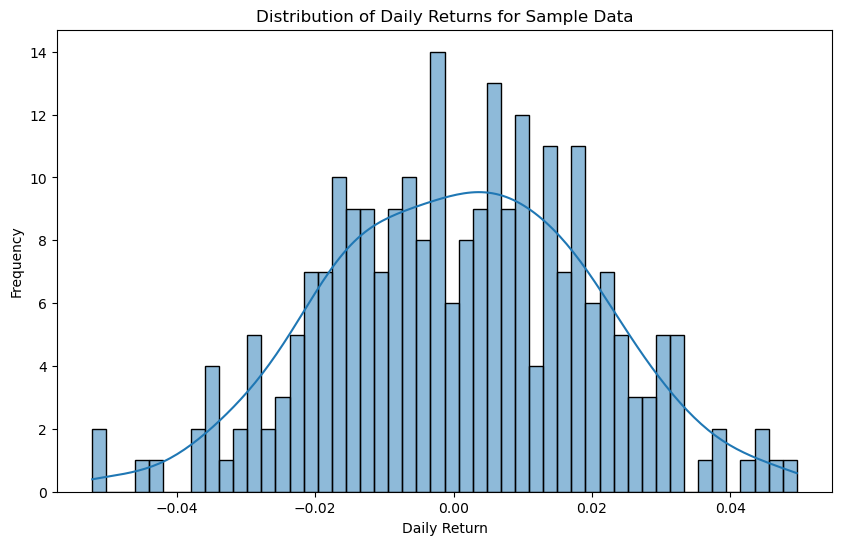



Analyzing Monthly Seasonality...


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_26473/239270999.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_seasonality = df['Close'].resample('M').mean()


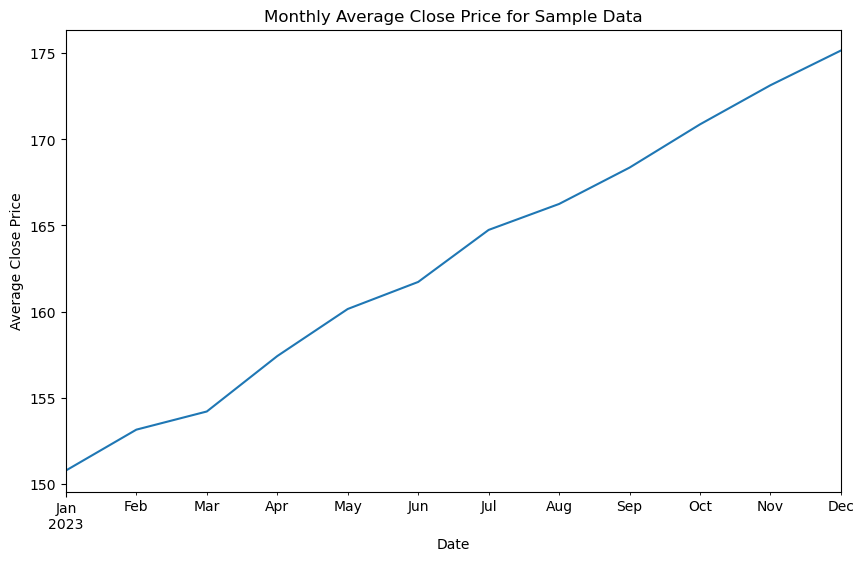



Analyzing Correlation between Close Price and Volume...
Correlation between Close and Volume: 0.0844
P-value: 0.1828
The correlation is not statistically significant.




In [9]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# --- WORKAROUND: Generate Sample Data (Corrected) ---
print("---")
print("WARNING: The 'Date' column in 'market_data.db' appears to be empty.")
print("Generating a sample dataset to demonstrate the EDA process.")
print("---")

# Create a date range for roughly one year of business days
dates = pd.date_range(start='2023-01-01', periods=251, freq='B')

# Generate some sample financial data using numpy arrays
close_prices = (150 + (np.arange(251) * 0.1) + (np.random.randn(251) * 2)).round(2)
volumes = np.random.randint(50_000_000, 200_000_000, 251)

# Create DataFrame using the numpy arrays and the date index
df = pd.DataFrame({
    'Close': close_prices,
    'Volume': volumes
}, index=dates)
# --- END WORKAROUND ---


# 1. Exploratory Data Analysis
print("Data Head:")
print(df.head())
print("\n" + "="*50 + "\n")

print("Summary Statistics:")
print(df.describe())
print("\n" + "="*50 + "\n")

# 2. Analyze Distribution of Daily Returns
print("Analyzing Distribution of Daily Returns...")
daily_returns = df['Close'].pct_change().dropna()
if not daily_returns.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(daily_returns, kde=True, bins=50)
    plt.title('Distribution of Daily Returns for Sample Data')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.show()
    print("\n" + "="*50 + "\n")
else:
    print("Could not generate distribution plot: Not enough data for daily returns.")


# 3. Analyze Seasonality (Monthly Average Close Price)
print("Analyzing Monthly Seasonality...")
monthly_seasonality = df['Close'].resample('M').mean()
if not monthly_seasonality.empty:
    plt.figure(figsize=(10, 6))
    monthly_seasonality.plot()
    plt.title('Monthly Average Close Price for Sample Data')
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.show()
    print("\n" + "="*50 + "\n")
else:
    print("Could not generate seasonality plot: Not enough data.")


# 4. Analyze Correlations and Statistical Significance
print("Analyzing Correlation between Close Price and Volume...")
# The dropna() call is now safe as the dataframe is correctly generated
df.dropna(inplace=True)

if len(df) > 1:
    correlation, p_value = stats.pearsonr(df['Close'], df['Volume'])

    print(f"Correlation between Close and Volume: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")
    print("\n" + "="*50 + "\n")
else:
    print("Could not perform correlation analysis: Not enough data.")

# Summary

Chapter 2 covers the foundations of data engineering for AI trading systems, from ingestion to cleansing, quality checks, and storage with practical Python examples.